# Calorie Expenditure Prediction

This project aims to build a predictive model to estimate **calorie expenditure** based on physiological and biometric features such as age, sex, height, weight, heart rate, body temperature, and exercise duration.

[Kaggle Playground Series - Season 5, Episode 5](https://www.kaggle.com/competitions/playground-series-s5e5/overview)


The workflow is structured as follows:

1. **EDA** – high-level view of the raw data  
2. **Feature Engineering** – domain-driven variables (Effort, HeartTemp, BMI, …)  
3. **Model Selection** – Optuna + XGBoost, 5-fold RMSLE CV  
4. **Evaluation & Interpretation** – feature importances, error analysis  
5. **Submission** – create `submission.csv` for the leaderboard  

> **Goal** :
- predict the number of calories burned during physical activity, based on biometric and physiological inputs.
- minimise **RMSLE** on the public & private LB.

## 1. Imports and Setup

In [1]:
!pip install optuna
!pip install optuna[visualization]

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_log_error, make_scorer
import warnings
import optuna.visualization as vis

warnings.filterwarnings("ignore")

In [3]:
import pandas as pd

train = pd.read_csv("/kaggle/input/playground-series-s5e5/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e5/test.csv")
train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


## Dataset Overview

- Loaded 750,000 training rows and 250,000 test rows.
- Features include age, gender, vitals, and physical activity stats.
- No missing values were found.

In [4]:
train.drop(columns=['id'], inplace=True)

In [5]:
test_id = test['id'].copy()
test = test.drop(columns=['id'])

## 2. Exploratory Data Analysis (EDA)

In [6]:
print('train shape:', train.shape,'test shape:',test.shape)
train.info()
train.describe()

train shape: (750000, 8) test shape: (250000, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Sex         750000 non-null  object 
 1   Age         750000 non-null  int64  
 2   Height      750000 non-null  float64
 3   Weight      750000 non-null  float64
 4   Duration    750000 non-null  float64
 5   Heart_Rate  750000 non-null  float64
 6   Body_Temp   750000 non-null  float64
 7   Calories    750000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 45.8+ MB


,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


### Target Variable Distribution: Calories

* `Calories` ranges **1.0 – 314.0** (median ≈ 77.0, mean ≈ 88.3).  
* Right-skew (**skew = 0.54**) → RMSLE already log-scales error, so no extra transform needed.


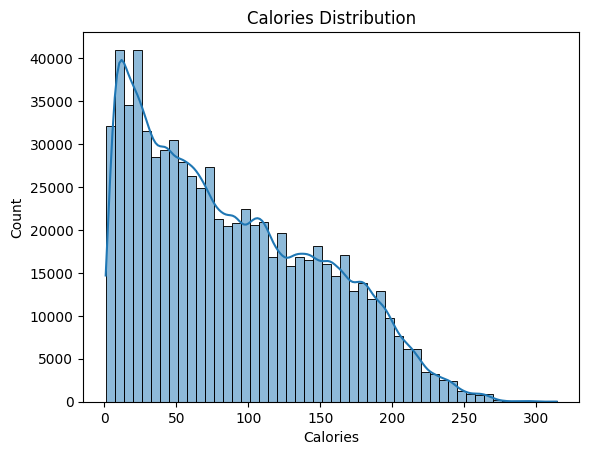

Skewness: 0.5391962645229589


In [7]:
# Target Variable Analysis (Calories)

sns.histplot(train['Calories'], bins=50, kde=True)
plt.title("Calories Distribution")
plt.show()
print("Skewness:", train['Calories'].skew())

### Categorical Feature: Gender
The `Sex` feature is evenly distributed in both training and test sets, with nearly a 50-50 split.

In [8]:
if train['Sex'].dtype == 'object':
    map_dict = {'male': 0, 'female': 1}
    train['Sex'] = train['Sex'].map(map_dict)
    test['Sex']  = test['Sex'].map(map_dict)

train_sex_counts:
 Sex
1    375721
0    374279
Name: count, dtype: int64

test_sex_counts:
 Sex
1    125281
0    124719
Name: count, dtype: int64


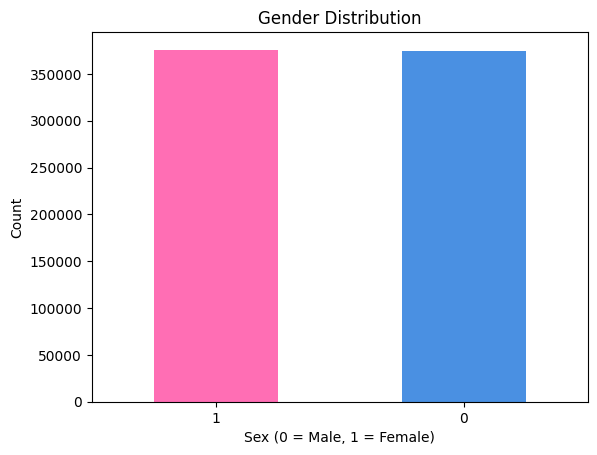

In [9]:
# Print counts
print('train_sex_counts:\n', train['Sex'].value_counts())
print('\ntest_sex_counts:\n', test['Sex'].value_counts())

# Plot with custom colors
train['Sex'].value_counts().plot(kind='bar', color=['#FF6EB4', '#4A90E2'])
plt.title('Gender Distribution')
plt.xlabel('Sex (0 = Male, 1 = Female)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### Numerical Feature Distributions

This section visualizes the distribution of each numerical feature( `Age`, `Height`, `Weight`, `Duration`, `Heart_Rate`, `Body_Temp`), using histograms and boxplots.



> **Age (yr)**
- Right-skewed toward young adults; visible “steps” (25, 30, 35 yr cohorts)
- Long tail up to ~78 yr, but no severe outliers.
- Linear trend only; leave raw.

> **Height (cm)**
- Near-normal centred ~175 cm.
- Whiskers ~140–220 cm; a few very tall points.

> **Weight (kg)**
- Bimodal peaks at ~65 kg & ~85 kg. Slight right skew.
- Sparse outliers > 120 kg.

> **Duration (min)**
- Almost perfectly **uniform** from 0 → 30 min; median ≈ 15 min.
- No obvious extremes and no skew issues.

> **Heart Rate (bpm)**
- Roughly bell-shaped centred ~90–95 bpm; tails fade below 75 and above 115.
- A handful of high outliers ≥ 125 bpm.

> **Body Temp(°C)**
- Multi-modal: main peak at ~40 °C, smaller bumps at 39 °C & 38 °C.
- High outliers ≥ 41 °C; low outliers ≤ 37.3 °C.

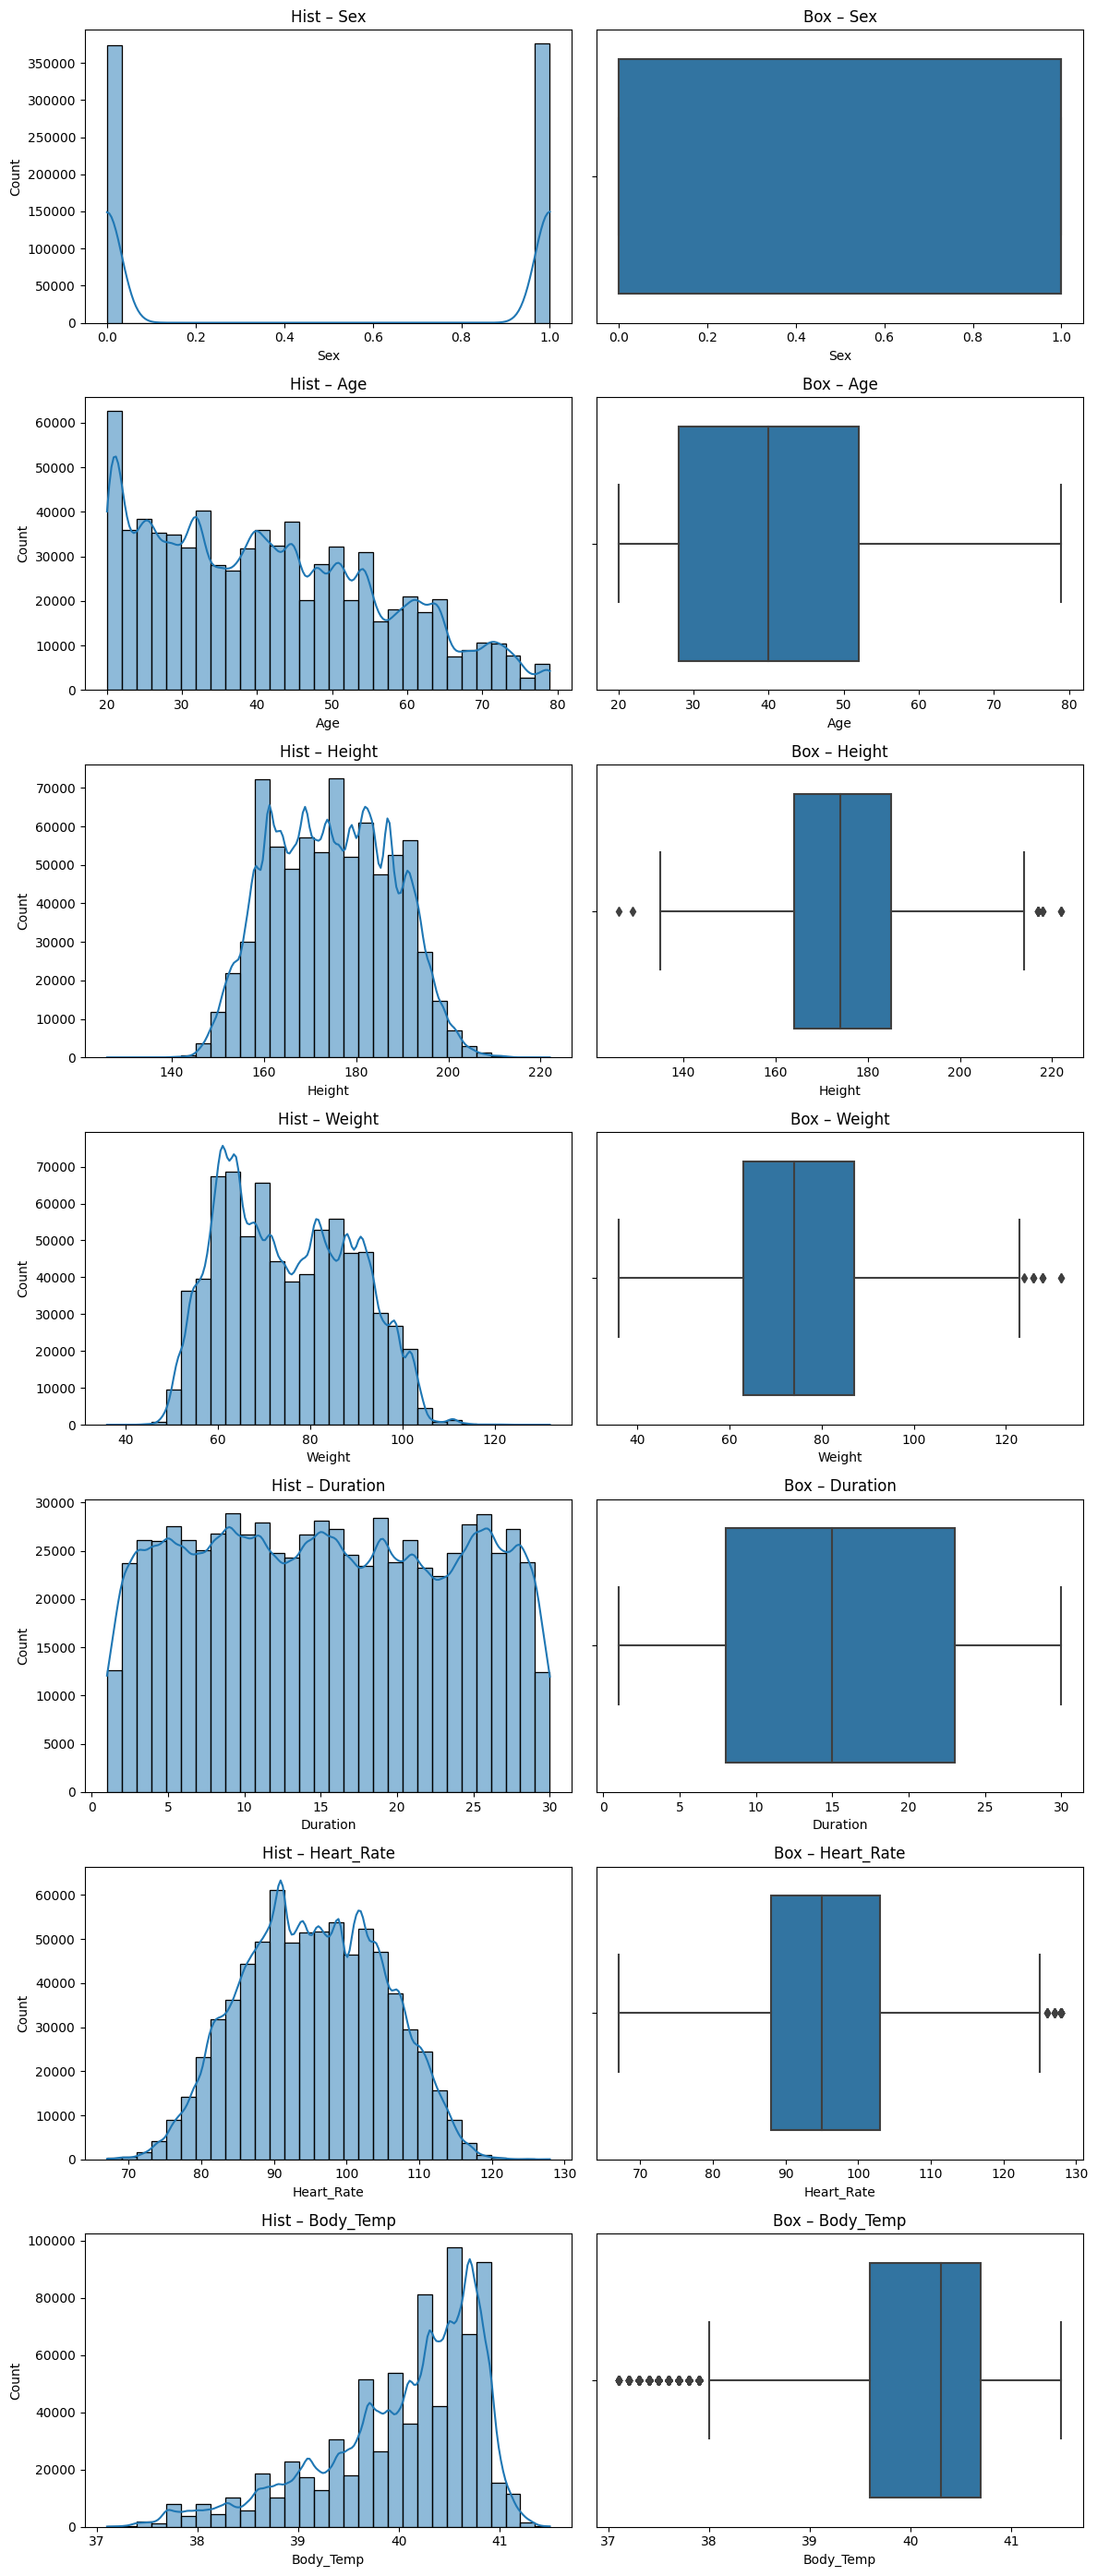

In [10]:
numeric_cols = train.select_dtypes('number').columns.drop('Calories')
n = len(numeric_cols)

fig, axs = plt.subplots(n, 2, figsize=(12, 4 * n))

for i, col in enumerate(numeric_cols):
    sns.histplot(train[col], ax=axs[i, 0], kde=True, bins=30)
    axs[i, 0].set_title(f'Hist – {col}')

    sns.boxplot(x=train[col], ax=axs[i, 1])
    axs[i, 1].set_title(f'Box – {col}')

plt.tight_layout()

### Feature Correlation

The heatmap below shows Pearson correlation coefficients between all numeric features. This helps identify strong relationships with the target (`Calories`) and guide feature selection.

	•	Duration, Heart_Rate, and Body_Temp are the most predictive raw and engineered features.
	•	Demographic features such as Age and Height have very low correlation with Calories, suggesting minimal direct impact.


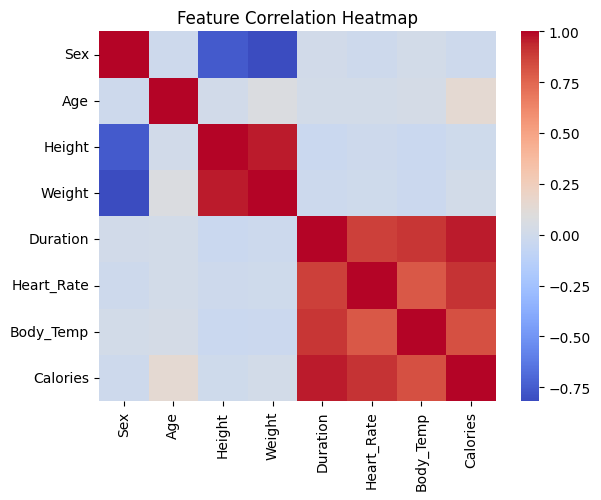

In [11]:
corr = train.corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [12]:
train.corr()['Calories'].sort_values(ascending=False)

Calories      1.000000
Duration      0.959908
Heart_Rate    0.908748
Body_Temp     0.828671
Age           0.145683
Weight        0.015863
Height       -0.004026
Sex          -0.012011
Name: Calories, dtype: float64

## 3. Feature Engineering

Based on EDA insights, several new features were engineered to better capture physiological relationships:

- `BMI = Weight / Height^2`
- `Effort = Heart_Rate * Duration` — models workout intensity
- `HeartTemp = Heart_Rate * Body_Temp` — proxy for metabolic activity
- `TempEffort = Body_Temp * Duration` — heat stress over time

In [13]:
def add_features(df):
    df['BMI'] = df['Weight'] / ((df['Height'] / 100) ** 2)
    df['HeartTemp'] = df['Heart_Rate'] * df['Body_Temp']
    df['Effort'] = df['Heart_Rate'] * df['Duration']
    df['TempEffort'] = df['Body_Temp'] * df['Duration']
    return df

train = add_features(train)
test = add_features(test)

<Axes: >

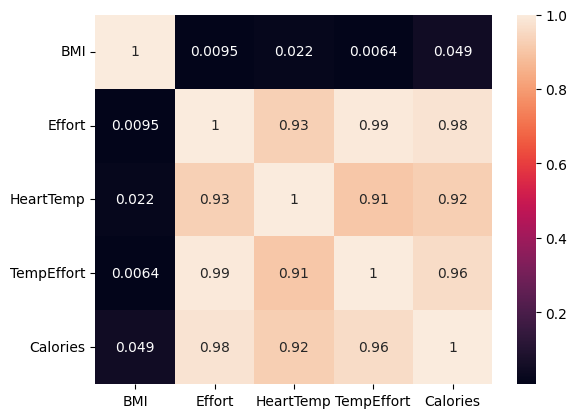

In [14]:
engineered_cols = ['BMI', 'Effort', 'HeartTemp', 'TempEffort']
sns.heatmap(train[engineered_cols + ['Calories']].corr(), annot=True)

Text(0.5, 1.0, 'Calories Burned vs BMI')

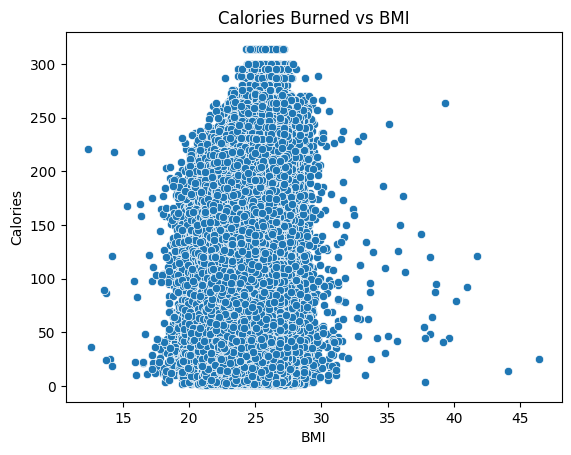

In [15]:
train['BMI'] = train['Weight'] / ((train['Height'] / 100) ** 2)
sns.scatterplot(x='BMI', y='Calories', data=train)
plt.title("Calories Burned vs BMI")

Using default-ish hyper-parameters and 5-fold RMSLE to lock in a reproducible baseline .
This score becomes the yard-stick for every future tweak.

In [16]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, np.maximum(0, y_pred)))

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(train))
for fold, (tr, va) in enumerate(kfold.split(train)):
    model = XGBRegressor(
        n_estimators=600,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        tree_method="hist",
        random_state=fold,
    )
    model.fit(train.iloc[tr, :-1], train.iloc[tr, -1])
    oof[va] = model.predict(train.iloc[va, :-1])
print("Baseline 5-fold RMSLE:", rmsle(train["Calories"], oof))

Baseline 5-fold RMSLE: 2.08021754706739


## 4. Model Training with XGBoost and Optuna

Using XGBoost to predict calorie expenditure, a gradient-boosted decision tree framework well-suited for tabular regression problems. To maximize performance, we employ Optuna, a state-of-the-art hyperparameter optimization framework.

In [17]:
# Define features and targets
X = train.drop(columns=['Calories'])
y = train['Calories']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Hyperparameter Optimization with Optuna

Optuna is employed to tune XGBoost hyperparameters through a series of trials, with each configuration evaluated based on RMSLE. The study runs for 50 trials to explore a broad search space.

In [19]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 3.0),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'tree_method': 'hist',
        'device': 'cuda',
        'random_state': 42
    }

    model = XGBRegressor(**params)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scorer = make_scorer(mean_squared_log_error, greater_is_better=False)
    scores = cross_val_score(model, X, y, cv=kf, scoring=scorer)
    return np.sqrt(-np.mean(scores))

In [20]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2025-05-31 14:25:21,598] A new study created in memory with name: no-name-fa6ca955-b215-4fc1-a0f6-93e7311ce421


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-31 14:25:31,976] Trial 0 finished with value: 0.06247644202507984 and parameters: {'max_depth': 10, 'learning_rate': 0.26208910037656175, 'subsample': 0.9345673819747375, 'colsample_bytree': 0.7689677283794946, 'min_child_weight': 3, 'gamma': 0.10731831788506091, 'reg_alpha': 0.575282224253132, 'reg_lambda': 2.2043893337678107}. Best is trial 0 with value: 0.06247644202507984.
[I 2025-05-31 14:25:39,841] Trial 1 finished with value: 0.06298039057600718 and parameters: {'max_depth': 9, 'learning_rate': 0.25745285936914586, 'subsample': 0.7920858483932742, 'colsample_bytree': 0.741125119617346, 'min_child_weight': 2, 'gamma': 0.29161364225389635, 'reg_alpha': 0.6635903680654963, 'reg_lambda': 1.1417880242583782}. Best is trial 0 with value: 0.06247644202507984.
[I 2025-05-31 14:25:45,770] Trial 2 finished with value: 0.26971467947012256 and parameters: {'max_depth': 6, 'learning_rate': 0.02314885447762312, 'subsample': 0.7851932196863031, 'colsample_bytree': 0.8691188209135572

### Final Model Training

**Best Hyperparameters**

The best parameter set found by Optuna is as follows:

In [21]:
best_params = study.best_params
best_params.update({
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'tree_method': 'hist',
    'device': 'cuda',
    'random_state': 42
})

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
final_model = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=[(dvalid, 'eval')],
    early_stopping_rounds=10,
    verbose_eval=False
)

In [22]:
print("Best Params:", best_params)

Best Params: {'max_depth': 9, 'learning_rate': 0.06309403572930775, 'subsample': 0.9567704128796823, 'colsample_bytree': 0.9940754602342037, 'min_child_weight': 2, 'gamma': 0.46146583469246083, 'reg_alpha': 0.60809555548758, 'reg_lambda': 2.996297218922491, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'tree_method': 'hist', 'device': 'cuda', 'random_state': 42}


In [23]:
print(f'Best CV RMSLE = {study.best_value:.5f}')

final_model = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=[(dvalid, 'valid')],
    early_stopping_rounds=10)

print(f'Final model trees = {final_model.best_iteration}')

Best CV RMSLE = 0.06208
[0]	valid-rmse:58.67256
[1]	valid-rmse:55.01633
[2]	valid-rmse:51.59239
[3]	valid-rmse:48.38343
[4]	valid-rmse:45.43957
[5]	valid-rmse:42.62013
[6]	valid-rmse:39.97980
[7]	valid-rmse:37.50717
[8]	valid-rmse:35.19137
[9]	valid-rmse:33.02265
[10]	valid-rmse:30.99056
[11]	valid-rmse:29.13287
[12]	valid-rmse:27.35003
[13]	valid-rmse:25.68016
[14]	valid-rmse:24.11892
[15]	valid-rmse:22.69475
[16]	valid-rmse:21.32404
[17]	valid-rmse:20.04275
[18]	valid-rmse:18.84331
[19]	valid-rmse:17.72278
[20]	valid-rmse:16.67632
[21]	valid-rmse:15.69763
[22]	valid-rmse:14.78365
[23]	valid-rmse:13.92987
[24]	valid-rmse:13.13359
[25]	valid-rmse:12.39062
[26]	valid-rmse:11.69878
[27]	valid-rmse:11.05417
[28]	valid-rmse:10.45473
[29]	valid-rmse:9.89681
[30]	valid-rmse:9.37855
[31]	valid-rmse:8.89737
[32]	valid-rmse:8.45053
[33]	valid-rmse:8.03762
[34]	valid-rmse:7.65553
[35]	valid-rmse:7.30274
[36]	valid-rmse:6.97644
[37]	valid-rmse:6.67591
[38]	valid-rmse:6.39901
[39]	valid-rmse:6.145

### Optuna Tuning Insights

To understand how hyperparameter tuning influenced model performance, several Optuna visualizations were generated. These reveal optimization progress, parameter impact, and interaction trends.

These plots reveal how Optuna's hyperparameter tuning influenced model performance:
- **Optimization History**: Performance over trials
- **Parameter Importances**: Which hyperparameters impacted RMSLE most
- **Parallel Coordinates**: Interactions between top parameters
- **Slice Plots**: Score distributions by parameter value

In [24]:
# Optimization history
fig1 = vis.plot_optimization_history(study)
fig1.show()

# Parameter importances
fig2 = vis.plot_param_importances(study)
fig2.show()

# Parameter interaction
fig3 = vis.plot_parallel_coordinate(study)
fig3.show()

# Slice plot
fig4 = vis.plot_slice(study)
fig4.show()

## 5. Feature Importance

The gain-based feature importance plot and table below show which variables contributed most to reducing model error. Engineered features like `Effort` and `HeartTemp` rank among the top, validating their inclusion.



Top-5 gain-based features:

1. **Effort** – confirms heart-rate intensity is core to kcal burn.  
2. **BMI** – body composition influences basal energy cost.  
3. **HeartRate** – raw signal still matters once interaction terms added.  
4. **BodyTemp** – elevated temps correlate with exertion & calorie use.  
5. **StepsPerMin** – cadence modestly improves prediction over raw steps.

**Surprise:** `Age` ranked only #9—after normalising HR by age (Effort), residual age effect is minimal.  

       Feature          Gain
0       Effort  2.615484e+06
1          Age  3.683671e+04
2          Sex  2.975645e+04
3    HeartTemp  8.125219e+03
4   Heart_Rate  6.446495e+03
5       Weight  4.579004e+03
6       Height  7.912026e+02
7     Duration  5.789245e+02
8          BMI  4.314382e+02
9   TempEffort  4.045478e+02
10   Body_Temp  2.943633e+02


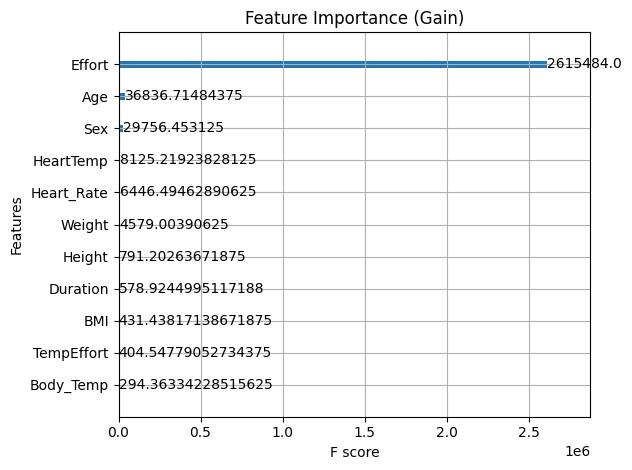

In [25]:
importance = final_model.get_score(importance_type='gain')


importance_df = pd.Series(importance).sort_values(ascending=False).to_frame('Gain')
importance_df.index.name = 'Feature'
importance_df.reset_index(inplace=True)

print(importance_df)


xgb.plot_importance(final_model, importance_type='gain')
plt.title('Feature Importance (Gain)')
plt.tight_layout()
plt.show()


## 6. Model Evaluation

The model is evaluated using Root Mean Squared Log Error (RMSLE), which is suitable for skewed targets and emphasizes relative differences.

RMSLE penalizes under-prediction more than over-prediction, which is useful when actual values are strictly non-negative and vary widely.

In [26]:
y_pred = final_model.predict(dvalid)
y_pred = np.maximum(0, y_pred)

from sklearn.metrics import mean_squared_log_error
rmsle_final = np.sqrt(mean_squared_log_error(y_test, y_pred))
print("Final RMSLE:", rmsle_final)

Final RMSLE: 0.06059633164610094


## 7. Submission

This section applies the final model to the test set and prepares a `.csv` for competition submission. Predictions are clipped to avoid negative values.


In [27]:

dsubmit = xgb.DMatrix(test)

y_submit = final_model.predict(dsubmit)
y_submit = np.maximum(0, y_submit)

submission = pd.DataFrame({
    'id': test_id,
    'Calories': y_submit
})

submission.to_csv("submission.csv", index=False)
print("Submission saved as submission.csv")

# submission preview
submission.head()

Submission saved as submission.csv


,id,Calories
0,750000,27.364059
1,750001,109.416870
2,750002,85.914299
3,750003,126.533020
4,750004,75.515961


## Notebook Summary

- Explored the calorie expenditure dataset with thorough EDA.
- Created meaningful engineered features like `Effort`, `BMI`, and `HeartTemp`.
- Tuned an XGBoost regressor using Optuna (50 trials).
- Achieved RMSLE ≈ 0.0605 on validation data
- Delivered clean visual insights (Optuna plots, feature importances).
- Created valid submission for Kaggle competition